In [70]:
import os
import json
import re
import numpy as np
import pandas as pd
from skimage.io import imread, imsave
import scipy.stats as stats
from matplotlib import pyplot as plt
from datetime import datetime

from scipy.signal import savgol_filter

### Making a dataframe from the results folders to handle the data

In [118]:
# params
path = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
#path = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'

In [119]:
df = pd.read_excel('Positions.xlsx')
df = df[df['Quality'] == 'Very good'].copy()
df_out = df.reset_index(drop=True)

# Initialize the columns as type 'object' to store arrays/lists
df_out.loc[:,["radius","area","max_av_gr"]] = np.nan
df_out['rad_dyn'] = pd.Series(dtype='object')
df_out['area_dyn'] = pd.Series(dtype='object')
df_out['av_gr_dyn'] = pd.Series(dtype='object')

# Assign an array to a cell in the DataFrame
# df_out.at[0, 'rad_dyn'] = np.array([0, 1, 2, 3, 4, 5])
# Similarly for 'area_dyn' if needed
# df_out.at[0, 'area_dyn'] = np.array([...])

# Display the head of the DataFrame to check the assignment
df_out.head()

,Date,Machine,Position,Strain,DNA,Chemical,Pad,Dilution,Quality,exp length,...,Centers,Radius,radj,wedge_adj,radius,area,max_av_gr,rad_dyn,area_dyn,av_gr_dyn
0,2023-11-15,Ti scope,0,MC4100,pLPT20+pLPT41,-,1,10^(-5),Very good,216,...,"600, 600",100.0,30.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-11-15,Ti scope,1,MC4100,pLPT20+pLPT41,-,1,10^(-5),Very good,216,...,"600, 600",100.0,50.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-11-15,Ti scope,2,MC4100,pLPT20+pLPT41,-,1,10^(-5),Very good,216,...,"600, 600",100.0,50.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-11-15,Ti scope,3,MC4100,pLPT20+pLPT41,-,1,10^(-5),Very good,216,...,"600, 600",100.0,30.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-11-15,Ti scope,6,MC4100,pLPT20+pLPT41,-,1,10^(-5),Very good,216,...,"625, 590",110.0,50.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
df_out.columns

Index(['Date', 'Machine', 'Position', 'Strain', 'DNA', 'Chemical', 'Pad',
       'Dilution', 'Quality', 'exp length', 'Colonies', 'Centers', 'Radius',
       'radj', 'wedge_adj', 'radius', 'area', 'max_av_gr', 'rad_dyn',
       'area_dyn', 'av_gr_dyn'],
      dtype='object')

#### Extract area and radius endpoints, as well as all dynamics

In [121]:
# extract area and radius from each position's results and store it in a dataframe
scopes = os.listdir(path)
for s in scopes:
    scope_dates = os.listdir(os.path.join(path,s))
    for d in scope_dates:
        date = datetime.strptime(d, '%Y_%m_%d')
        data = df[(df.Date == date) & (df.Machine == s)]
        pos = data.Position.unique()
        path_results = os.path.join(path,s,d,'results')
        for p in pos:
            path_pos = os.path.join(path_results,f'pos{p}')
            area_path = os.path.join(path_pos, 'area.npy')
            radius_path = os.path.join(path_pos, 'radius.npy')
            
            # load area and radius
            area = np.load(area_path)
            radius = np.load(radius_path)    
            area_diff = np.diff(area)
            av_gr = savgol_filter(area_diff / area[1:],21,3)
            
            # assigning
            ridx = df_out[(df_out.Date == date) & (df_out.Machine==s) & (df_out.Position == p)].index[0]
            df_out.loc[ridx, 'radius'] = radius[-1]
            df_out.loc[ridx, 'area'] = area[-1]
            df_out.loc[ridx, 'max_av_gr'] = np.nanmax(av_gr[np.isfinite(av_gr)])
            
            df_out.at[ridx, 'rad_dyn'] = radius
            df_out.at[ridx, 'area_dyn'] = area
            df_out.at[ridx, 'av_gr_dyn'] = av_gr

/tmp/ipykernel_4994/3726992417.py:19: RuntimeWarning: invalid value encountered in divide
  av_gr = savgol_filter(area_diff / area[1:],21,3)
/tmp/ipykernel_4994/3726992417.py:19: RuntimeWarning: divide by zero encountered in divide
  av_gr = savgol_filter(area_diff / area[1:],21,3)


In [122]:
df_out.to_excel('out.xlsx')

In [123]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

### Plotting mean radius filtered by date, machine and dilution

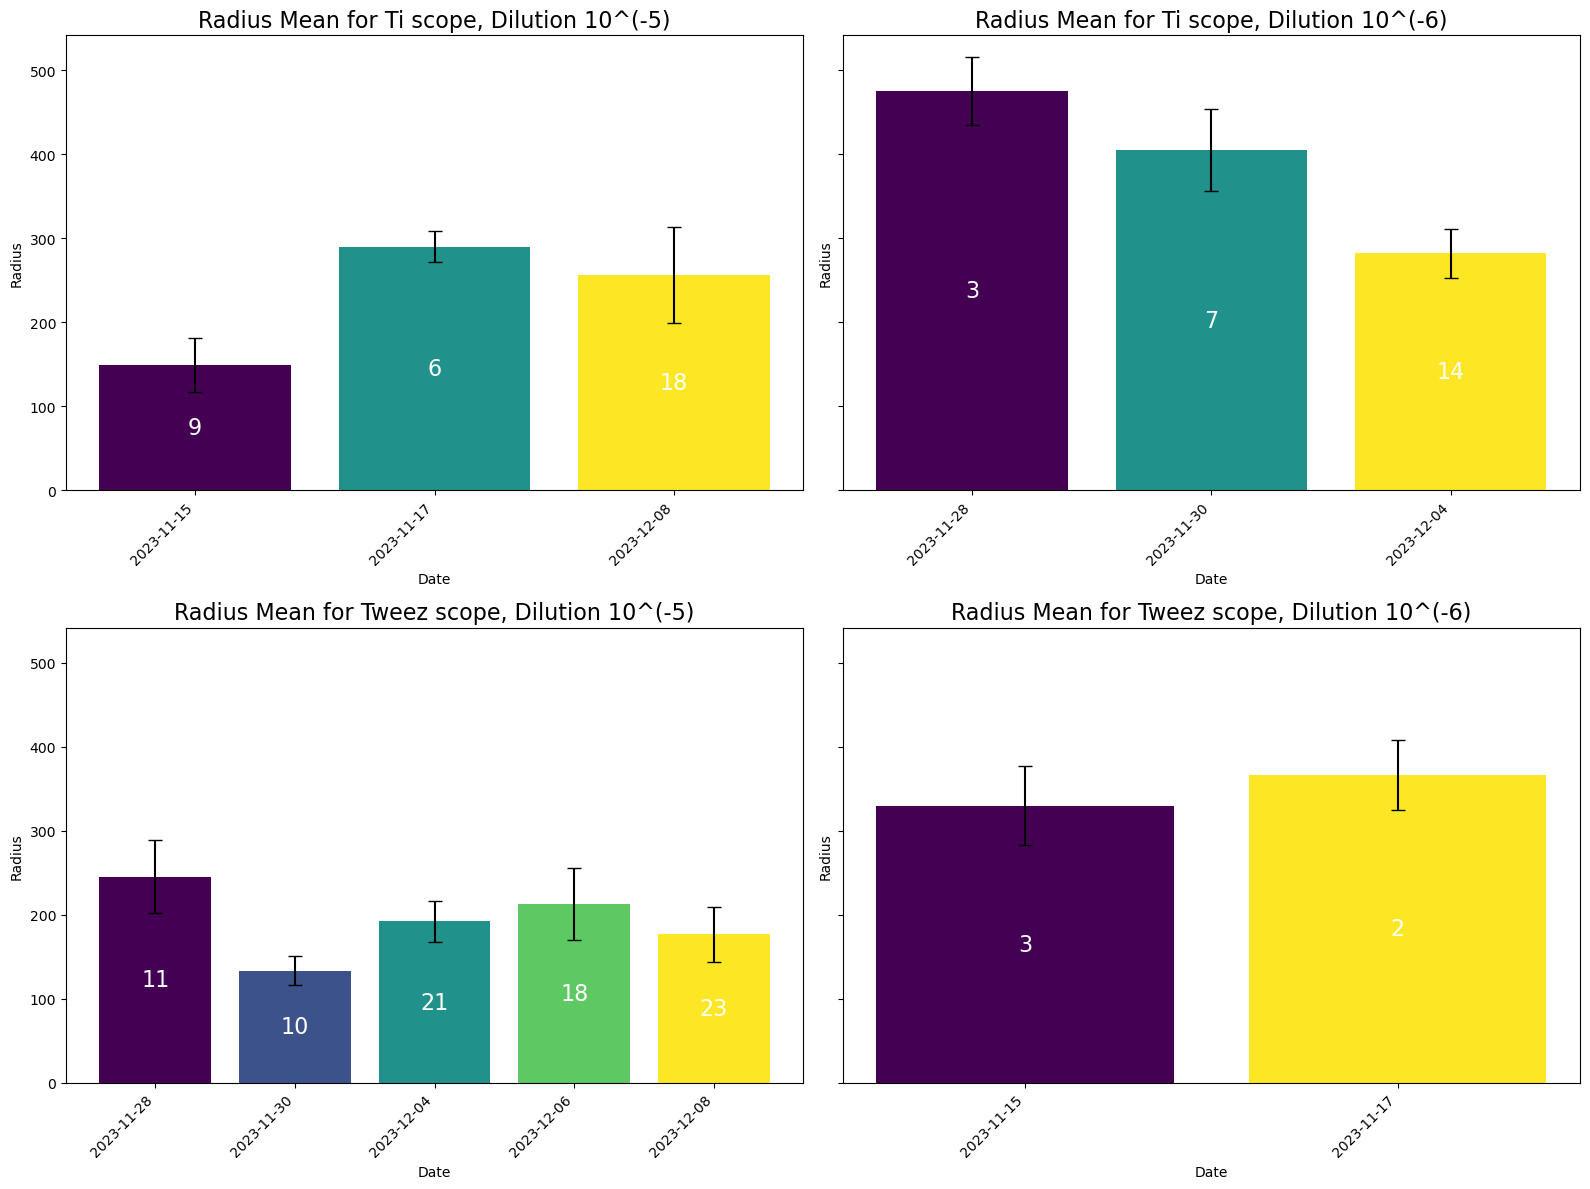

In [95]:
# Group the data by 'Date', 'Machine', 'Dilution', and calculate mean, standard deviation for 'radius' and count colonies
plot_data = df.groupby(['Date', 'Machine', 'Dilution']).agg({
    'radius': ['mean', 'std'],
    'Colonies': 'size'  # This will count the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Date', 'Machine', 'Dilution', 'Radius Mean', 'Radius Std', 'Colonies Count']

# Filter data for each machine and dilution type
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharey=True)
machine_dilutions = plot_data['Machine'].unique()
dilutions = plot_data['Dilution'].unique()

# Use a nested loop to create a subplot for each machine-dilution combination
for i, machine in enumerate(machine_dilutions):
    for j, dilution in enumerate(dilutions):
        sub_data = plot_data[(plot_data['Machine'] == machine) & (plot_data['Dilution'] == dilution)]
        if sub_data.empty:
            axes[i, j].set_xticks([])  # No data for this subplot
            continue
        radius_colors = plt.cm.viridis(np.linspace(0, 1, len(sub_data)))
        index = 0  # Initialize counter for the color array
        for _, row in sub_data.iterrows():
            bar = axes[i, j].bar(index, row['Radius Mean'], yerr=row['Radius Std'], capsize=5, color=radius_colors[index])
            # Annotate the number of colonies inside the bar
            axes[i, j].text(index, row['Radius Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=16)
            index += 1  # Increment counter
        
        axes[i, j].set_title(f'Radius Mean for {machine}, Dilution {dilution}', fontsize=16)
        axes[i, j].set_xlabel('Date')
        axes[i, j].set_ylabel('Radius')
        axes[i, j].set_xticks(range(len(sub_data)))
        axes[i, j].set_xticklabels([f"{row['Date'].date()}" for _, row in sub_data.iterrows()], rotation=45, ha="right")

plt.tight_layout()
plt.show()


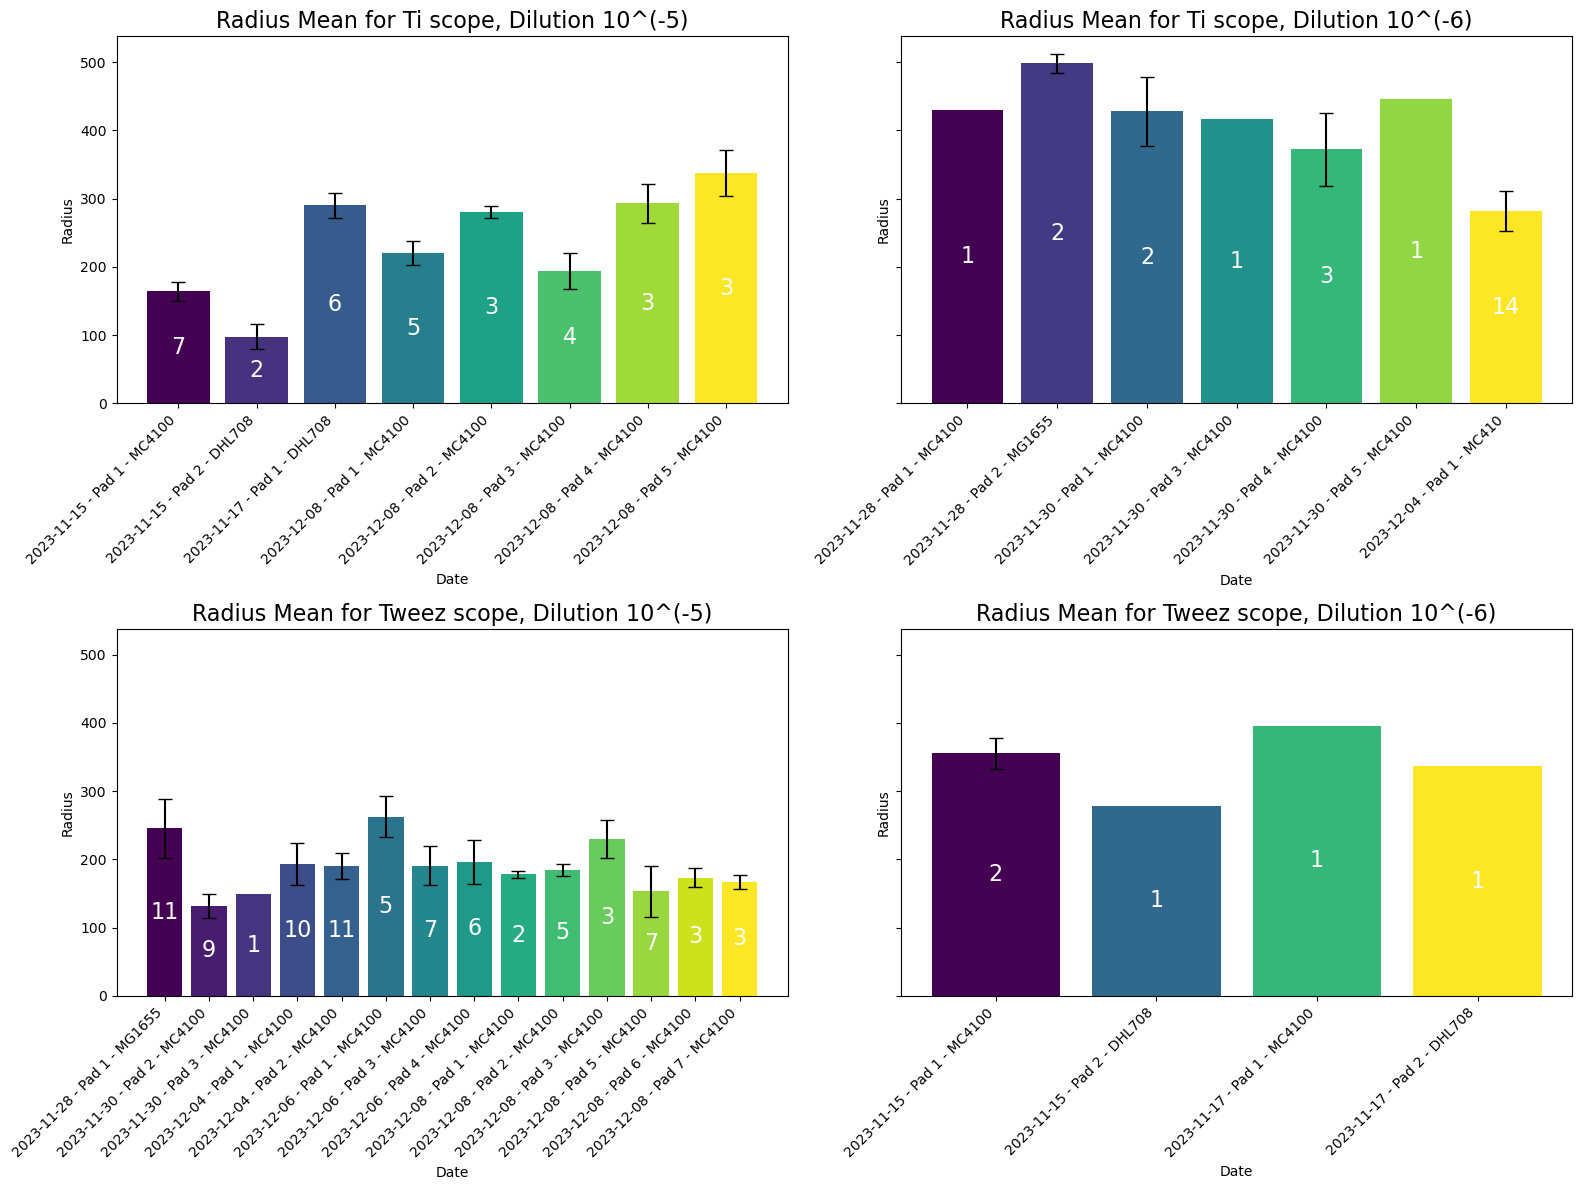

In [96]:
# Group the data by 'Date', 'Machine', 'Dilution', 'Pad', 'Strain' and calculate mean, standard deviation for 'radius' and count colonies
plot_data = df.groupby(['Date', 'Machine', 'Dilution', 'Pad', 'Strain']).agg({
    'radius': ['mean', 'std'],
    'Colonies': 'size'  # This will count the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Date', 'Machine', 'Dilution', 'Pad', 'Strain', 'Radius Mean', 'Radius Std', 'Colonies Count']

# Filter data for each machine and dilution type
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharey=True)
machine_dilutions = plot_data['Machine'].unique()
dilutions = plot_data['Dilution'].unique()

# Use a nested loop to create a subplot for each machine-dilution combination
for i, machine in enumerate(machine_dilutions):
    for j, dilution in enumerate(dilutions):
        sub_data = plot_data[(plot_data['Machine'] == machine) & (plot_data['Dilution'] == dilution)]
        if sub_data.empty:
            axes[i, j].set_xticks([])  # No data for this subplot
            continue
        radius_colors = plt.cm.viridis(np.linspace(0, 1, len(sub_data)))
        index = 0  # Initialize counter for the color array
        for _, row in sub_data.iterrows():
            bar = axes[i, j].bar(index, row['Radius Mean'], yerr=row['Radius Std'], capsize=5, color=radius_colors[index])
            # Annotate the number of colonies inside the bar
            axes[i, j].text(index, row['Radius Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=16)
            index += 1  # Increment counter
        
        axes[i, j].set_title(f'Radius Mean for {machine}, Dilution {dilution}', fontsize=16)
        axes[i, j].set_xlabel('Date')
        axes[i, j].set_ylabel('Radius')
        axes[i, j].set_xticks(range(len(sub_data)))
        axes[i, j].set_xticklabels([f"{row['Date'].date()} - Pad {row['Pad']} - {row['Strain']}" for _, row in sub_data.iterrows()], rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [97]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

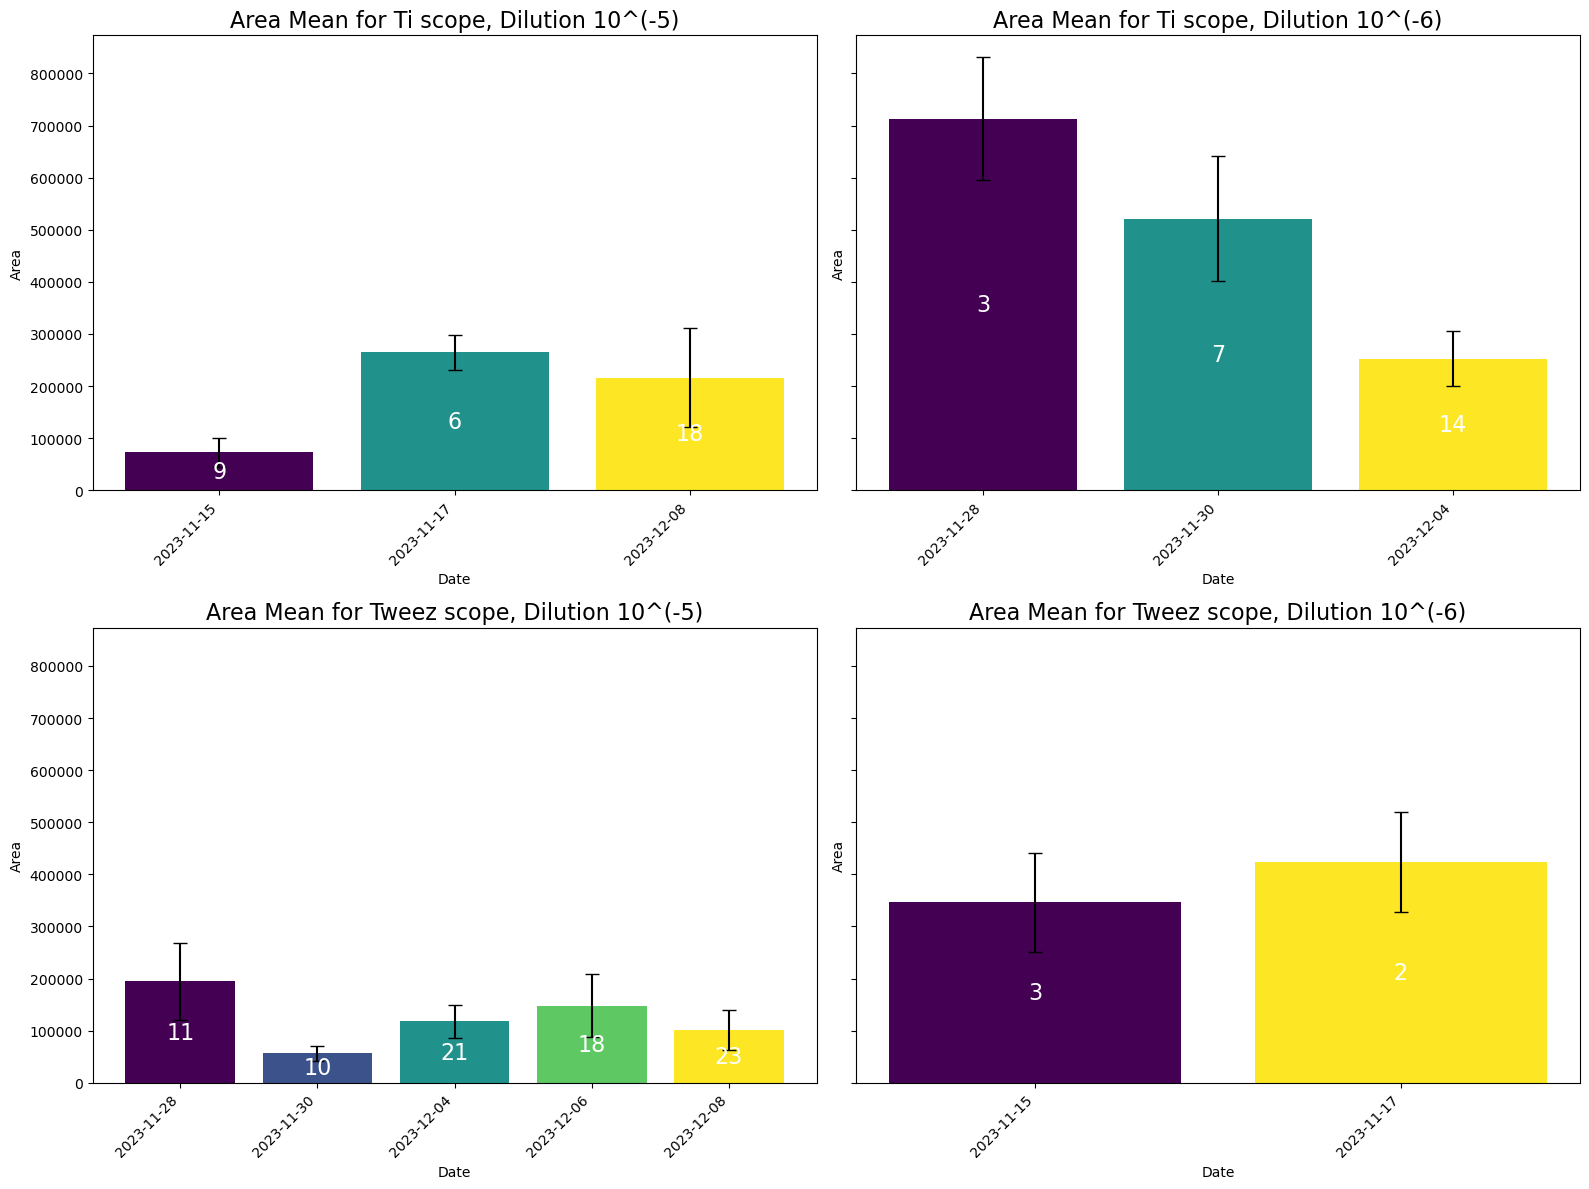

In [98]:
# Here we group by 'Date', 'Machine', 'Dilution' and calculate mean, standard deviation for 'area' and count colonies
plot_data = df.groupby(['Date', 'Machine', 'Dilution']).agg({
    'area': ['mean', 'std'],
    'Colonies': 'size'  # This will count the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Date', 'Machine', 'Dilution', 'Area Mean', 'Area Std', 'Colonies Count']

# Filter data for each machine and dilution type
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharey=True)
machine_dilutions = plot_data['Machine'].unique()
dilutions = plot_data['Dilution'].unique()

# Use a nested loop to create a subplot for each machine-dilution combination
for i, machine in enumerate(machine_dilutions):
    for j, dilution in enumerate(dilutions):
        sub_data = plot_data[(plot_data['Machine'] == machine) & (plot_data['Dilution'] == dilution)]
        if sub_data.empty:
            axes[i, j].set_xticks([])  # No data for this subplot
            continue
        area_colors = plt.cm.viridis(np.linspace(0, 1, len(sub_data)))
        index = 0  # Initialize counter for the color array
        for _, row in sub_data.iterrows():
            bar = axes[i, j].bar(index, row['Area Mean'], yerr=row['Area Std'], capsize=5, color=area_colors[index])
            # Annotate the number of colonies inside the bar
            axes[i, j].text(index, row['Area Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=16)
            index += 1  # Increment counter
        
        axes[i, j].set_title(f'Area Mean for {machine}, Dilution {dilution}', fontsize=16)
        axes[i, j].set_xlabel('Date')
        axes[i, j].set_ylabel('Area')
        axes[i, j].set_xticks(range(len(sub_data)))
        axes[i, j].set_xticklabels([f"{row['Date'].date()}" for _, row in sub_data.iterrows()], rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [104]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

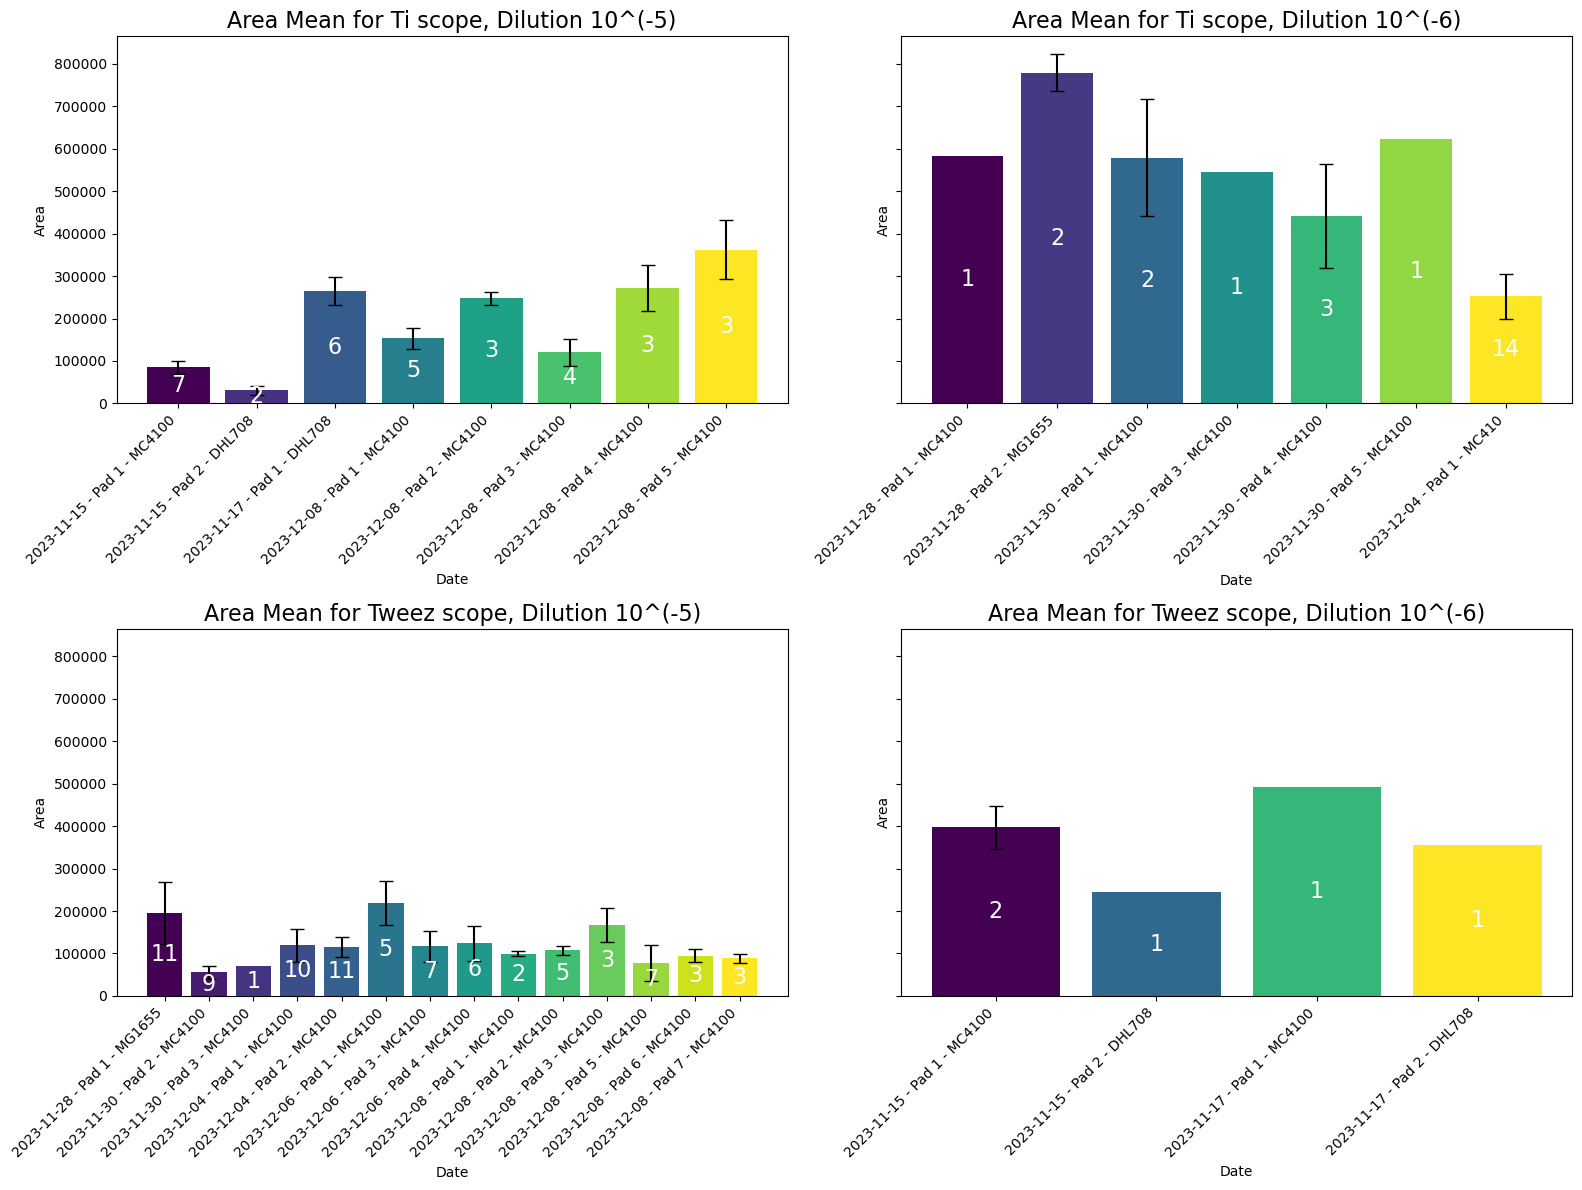

In [105]:
# Group the data by 'Date', 'Machine', 'Dilution', 'Pad', 'Strain' and calculate mean, standard deviation for 'area' and count colonies
plot_data = df.groupby(['Date', 'Machine', 'Dilution', 'Pad', 'Strain']).agg({
    'area': ['mean', 'std'],
    'Colonies': 'size'  # This will count the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Date', 'Machine', 'Dilution', 'Pad', 'Strain', 'Area Mean', 'Area Std', 'Colonies Count']

# Filter data for each machine and dilution type
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharey=True)
machine_dilutions = plot_data['Machine'].unique()
dilutions = plot_data['Dilution'].unique()

# Use a nested loop to create a subplot for each machine-dilution combination
for i, machine in enumerate(machine_dilutions):
    for j, dilution in enumerate(dilutions):
        sub_data = plot_data[(plot_data['Machine'] == machine) & (plot_data['Dilution'] == dilution)]
        if sub_data.empty:
            axes[i, j].set_xticks([])  # No data for this subplot
            continue
        area_colors = plt.cm.viridis(np.linspace(0, 1, len(sub_data)))
        index = 0  # Initialize counter for the color array
        for _, row in sub_data.iterrows():
            bar = axes[i, j].bar(index, row['Area Mean'], yerr=row['Area Std'], capsize=5, color=area_colors[index])
            # Annotate the number of colonies inside the bar
            axes[i, j].text(index, row['Area Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=16)
            index += 1  # Increment counter
        
        axes[i, j].set_title(f'Area Mean for {machine}, Dilution {dilution}', fontsize=16)
        axes[i, j].set_xlabel('Date')
        axes[i, j].set_ylabel('Area')
        axes[i, j].set_xticks(range(len(sub_data)))
        axes[i, j].set_xticklabels([f"{row['Date'].date()} - Pad {row['Pad']} - {row['Strain']}" for _, row in sub_data.iterrows()], rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [101]:
df_out.loc[0, "radius"]

153.1699388299685

In [10]:
def extract_array(s):
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", s)
    return np.array([float(num) for num in numbers])

### Plot growth dynamics for all the colonies

In [155]:
def extract_array(s):
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", s)
    return np.array([float(num) for num in numbers])

In [161]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

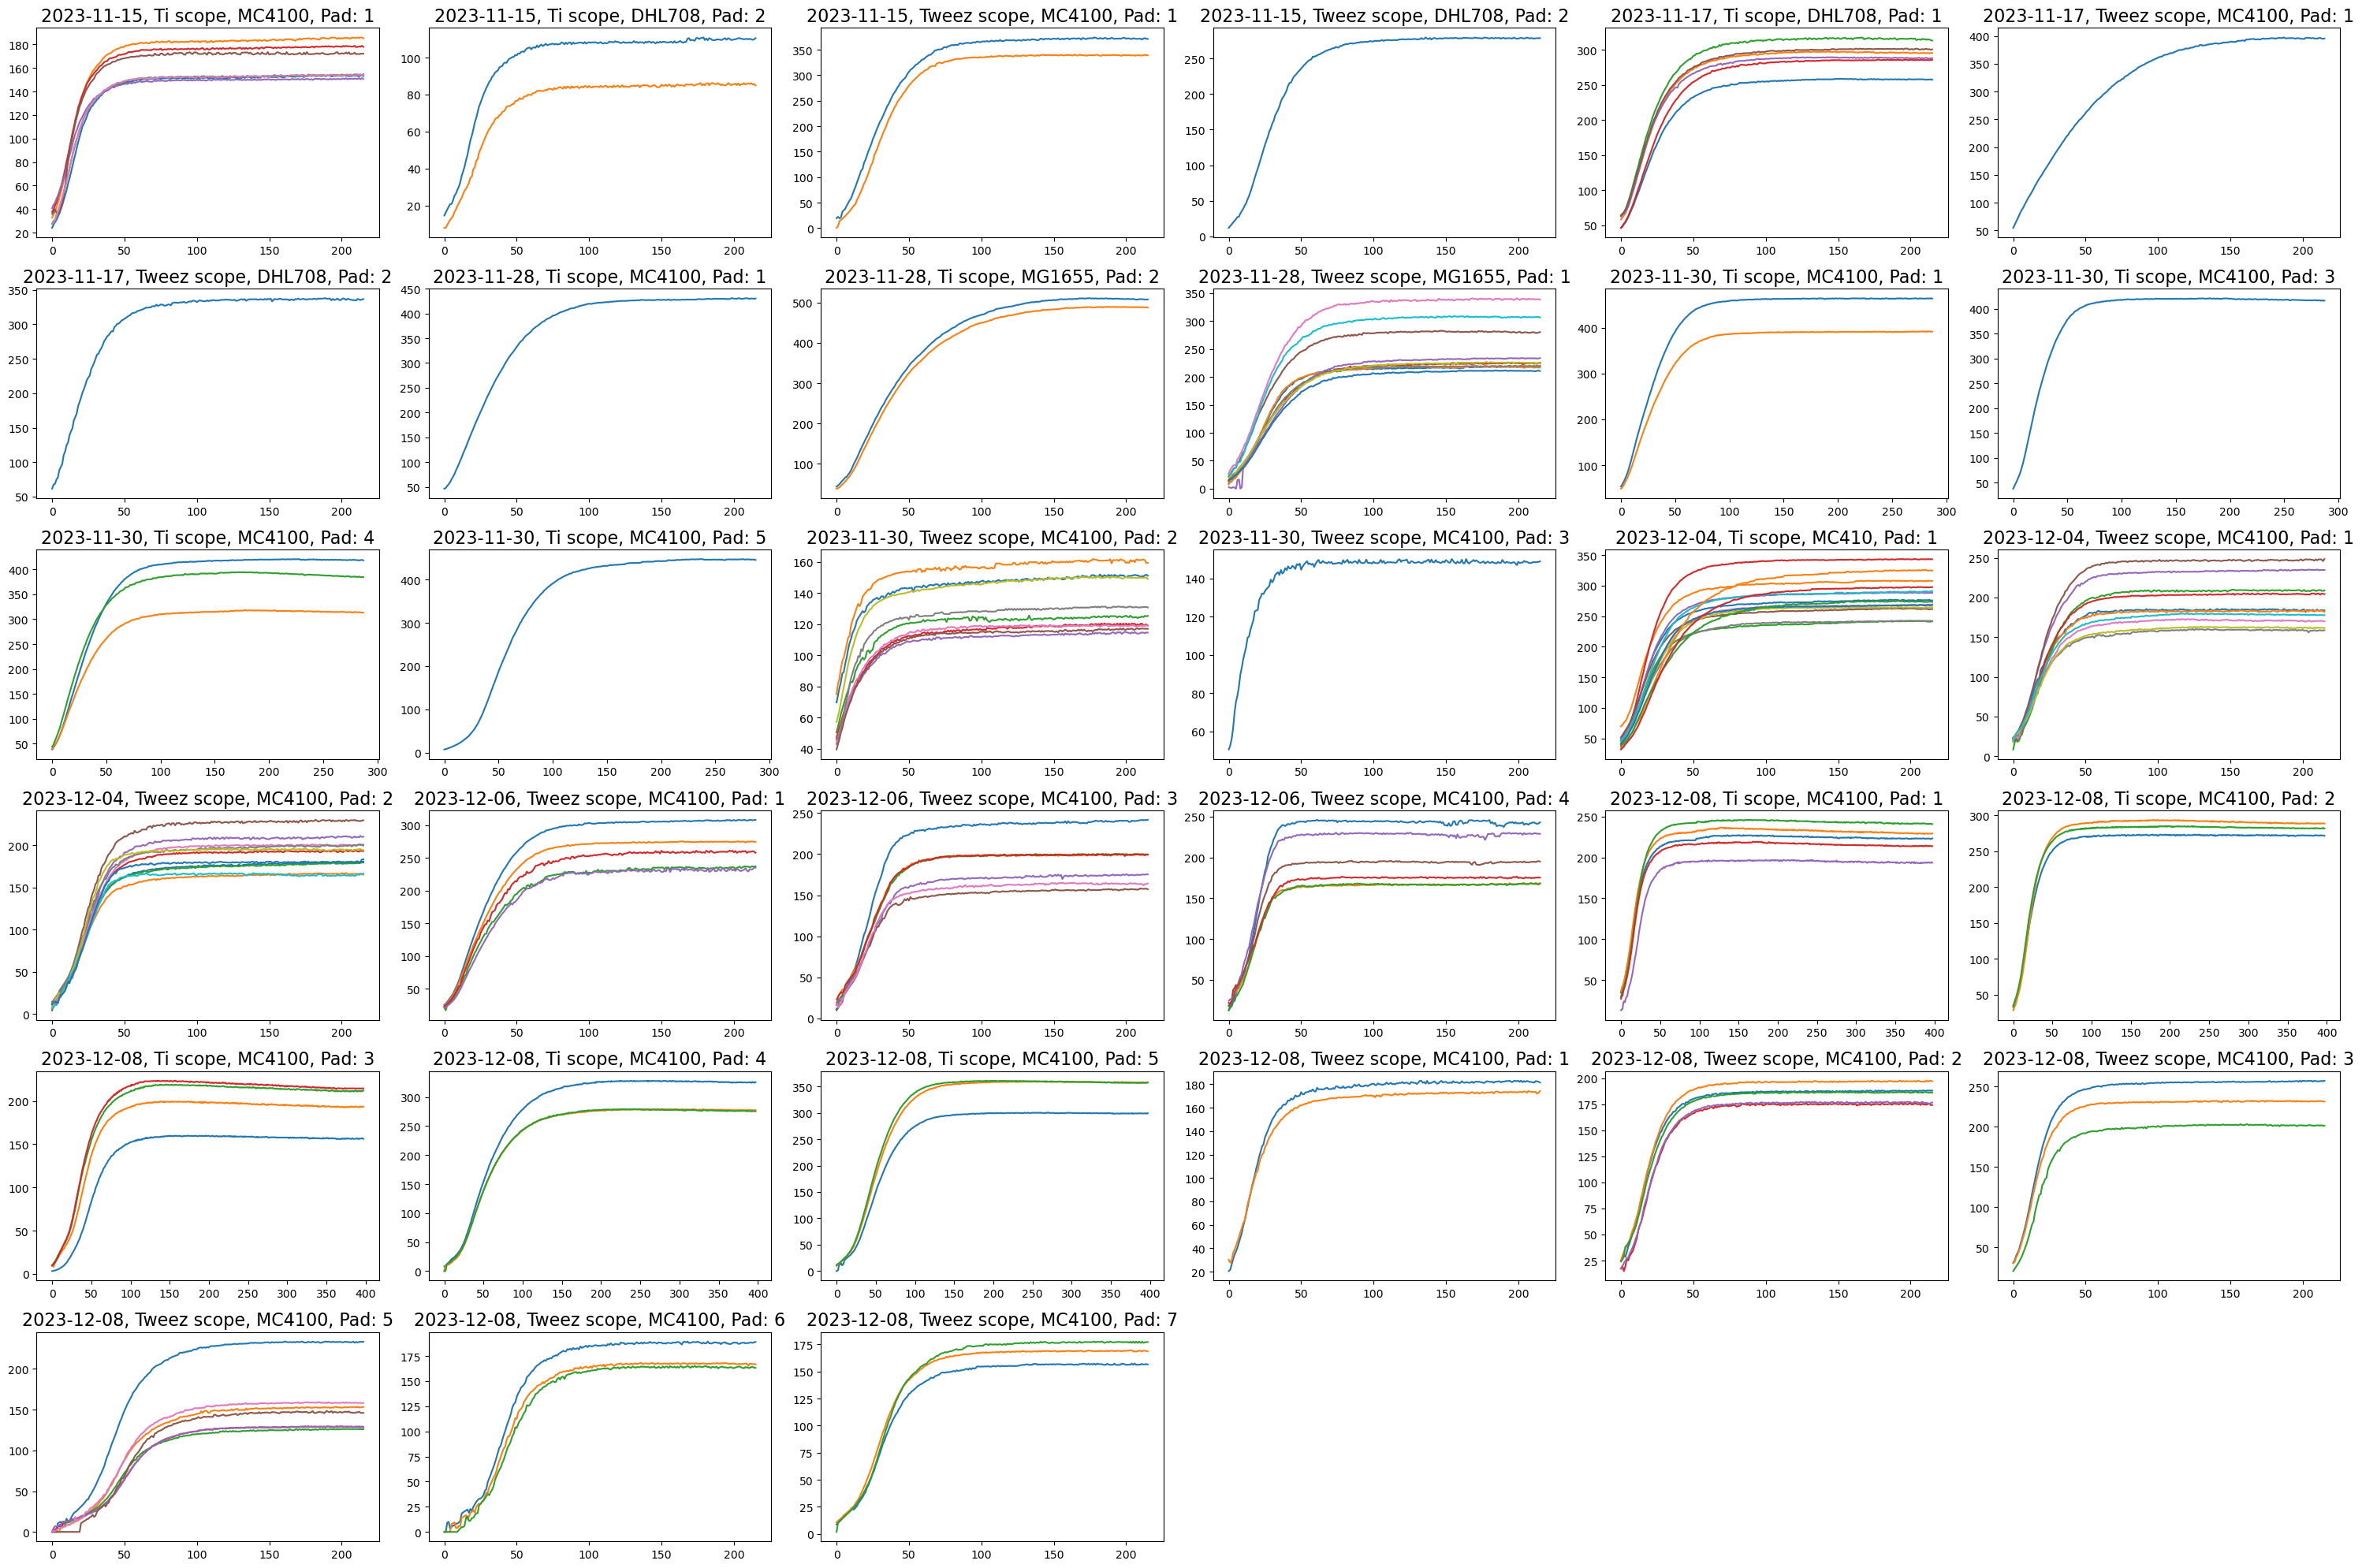

In [162]:
# Apply the extraction function to each row in the 'rad_dyn' column
df_out['rad_dyn'] = df_out['rad_dyn'].apply(extract_array)

# Group by 'Date', 'Machine', 'Pad', and 'Strain'
grouped = df_out.groupby(['Date', 'Machine', 'Pad', 'Strain'])

# Setup the plot - determine the layout based on the number of groups
group_count = len(grouped)
nrows = int(np.ceil(np.sqrt(group_count)))
ncols = int(np.ceil(group_count / nrows))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 20), squeeze=False)
axes = axes.flatten()

# Plot each group in a subplot
for ((date, machine, pad, strain), group), ax in zip(grouped, axes):
    for arr in group['rad_dyn']:
        ax.plot(arr)  # You might want to label these if needed
    # Format the date to only show year-month-day
    date_formatted = date.strftime('%Y-%m-%d')
    # Set the title to include the formatted date, machine name, pad, and strain
    ax.set_title(f'{date_formatted}, {machine}, {strain}, Pad: {pad}', fontsize=16)

# Hide any unused axes if there are any
for i in range(len(grouped), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [170]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

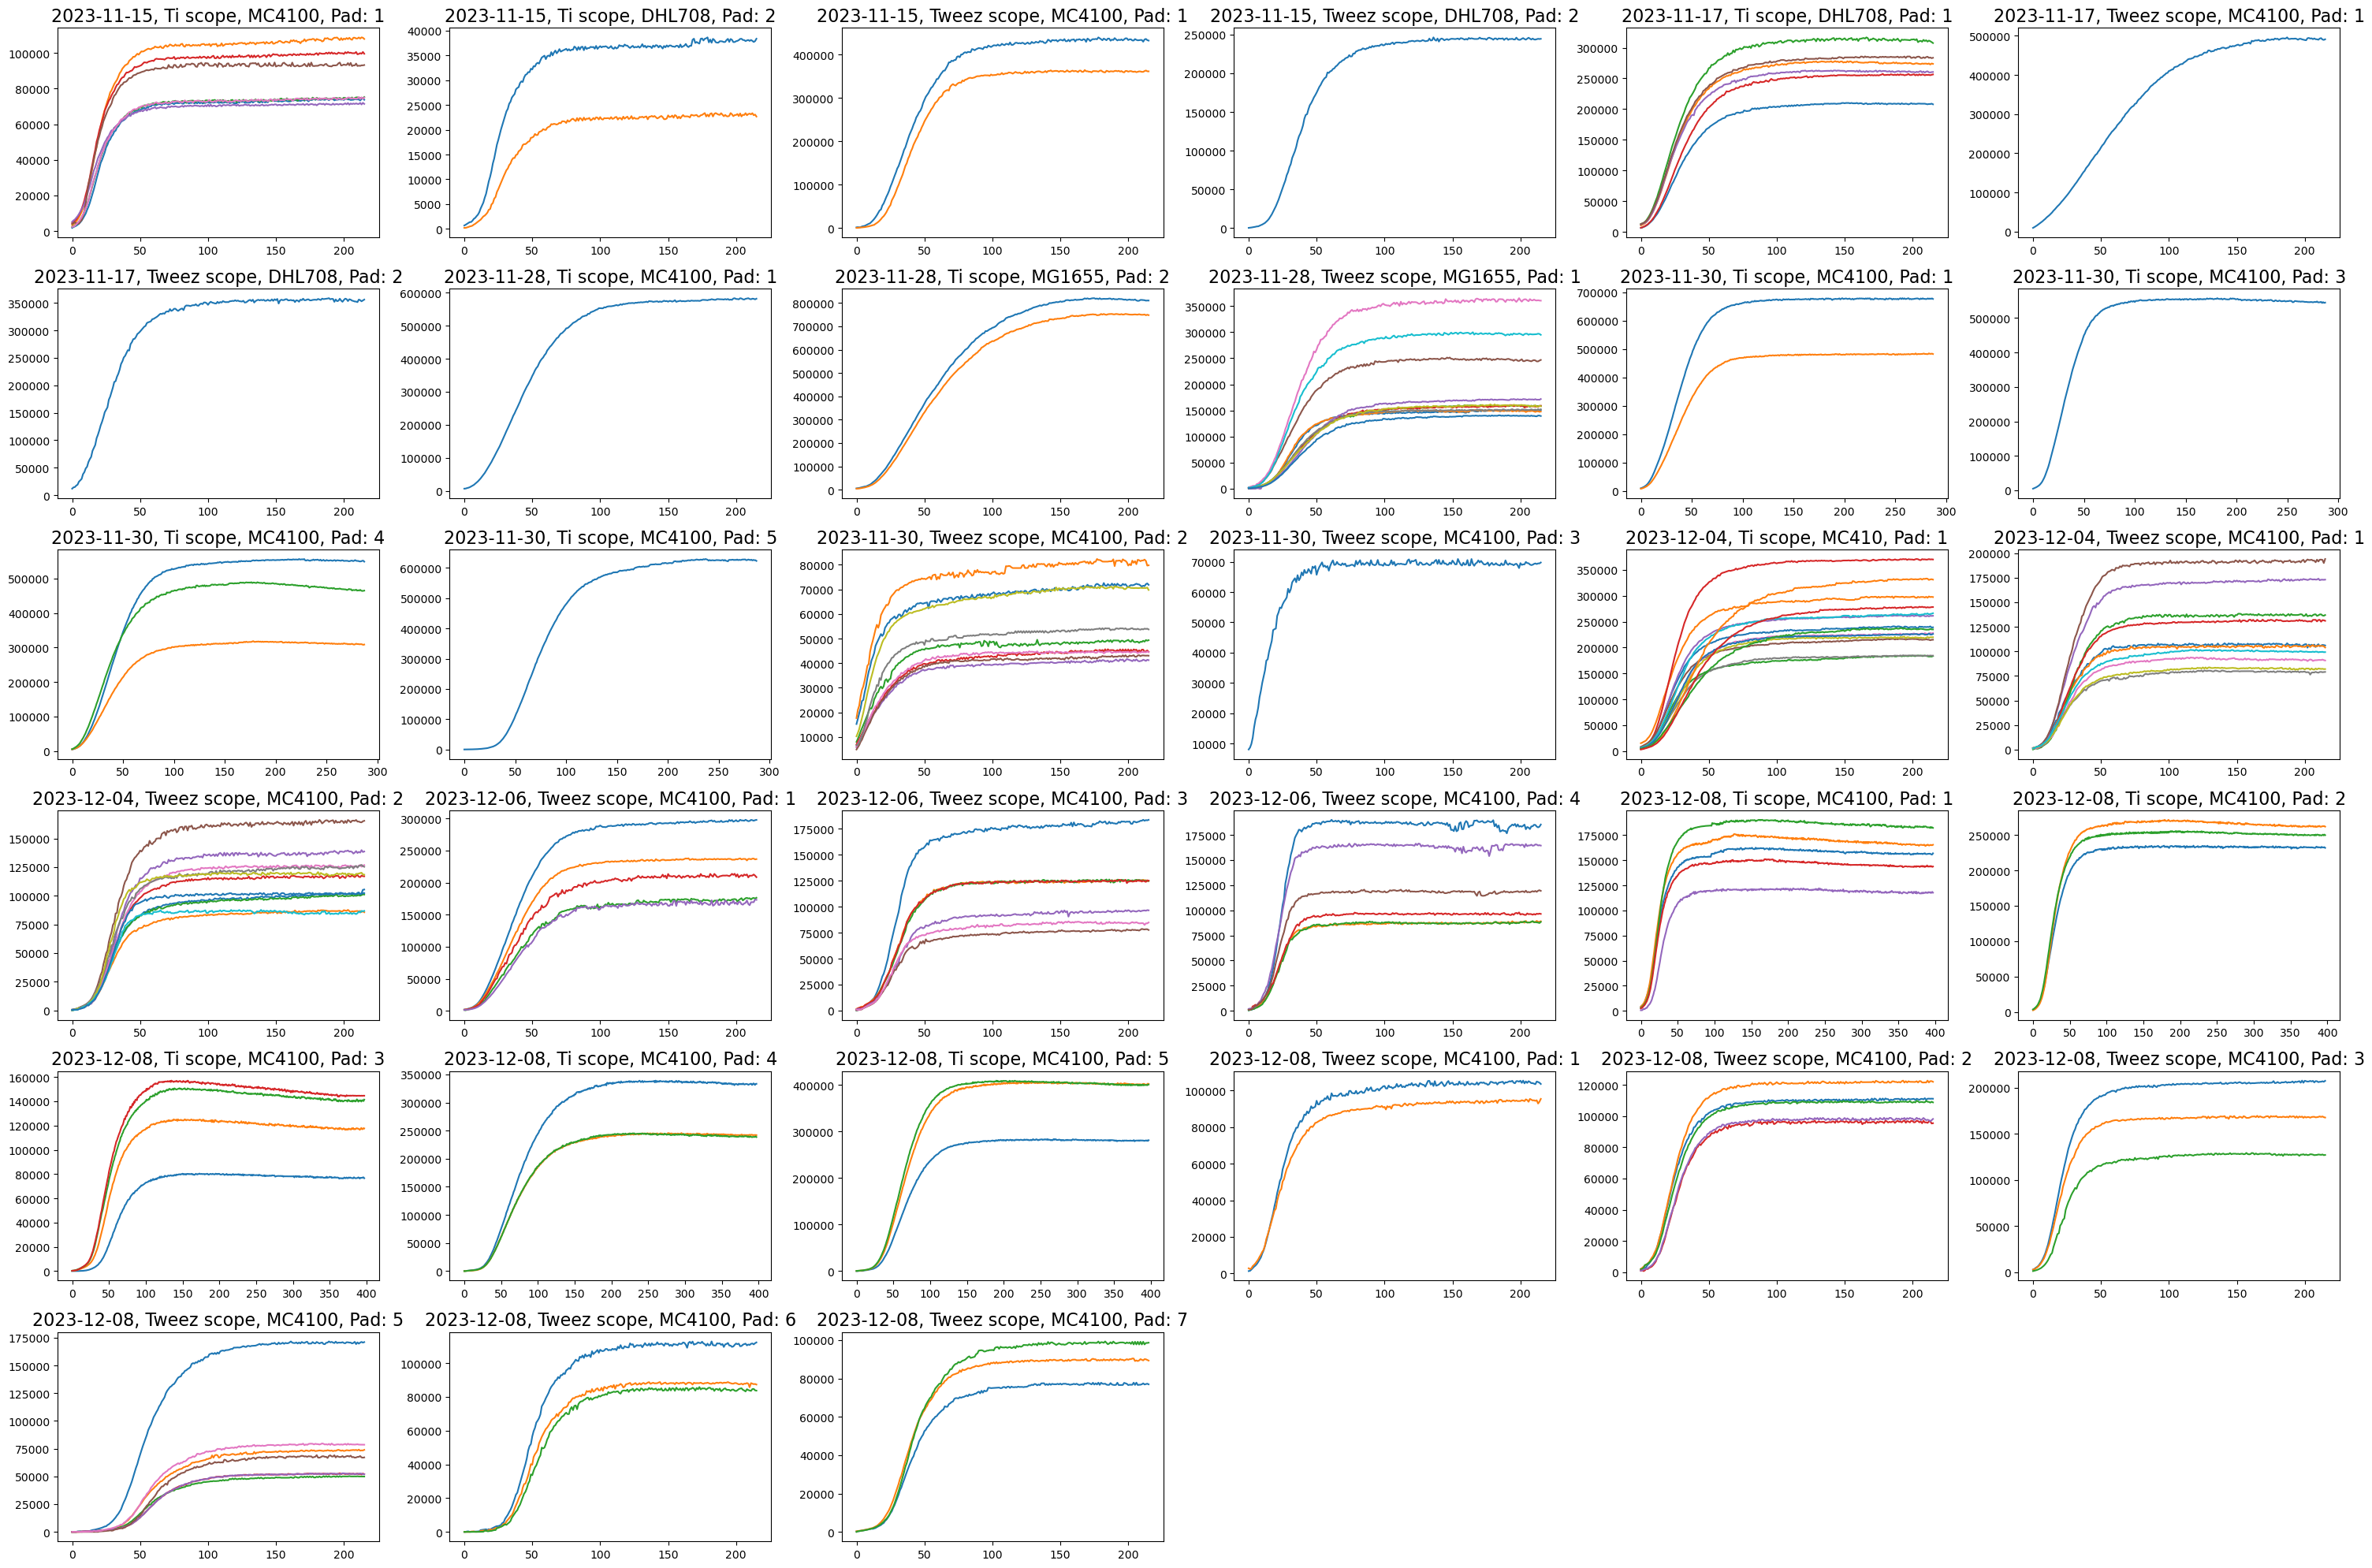

In [171]:
# Apply the extraction function to each row in the 'rad_dyn' column
df_out['area_dyn'] = df_out['area_dyn'].apply(extract_array)

# Group by 'Date', 'Machine', 'Pad', and 'Strain'
grouped = df_out.groupby(['Date', 'Machine', 'Pad', 'Strain'])

# Setup the plot - determine the layout based on the number of groups
group_count = len(grouped)
nrows = int(np.ceil(np.sqrt(group_count)))
ncols = int(np.ceil(group_count / nrows))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 20), squeeze=False)
axes = axes.flatten()

# Plot each group in a subplot
for ((date, machine, pad, strain), group), ax in zip(grouped, axes):
    for arr in group['area_dyn']:
        ax.plot(arr)  # You might want to label these if needed
    # Format the date to only show year-month-day
    date_formatted = date.strftime('%Y-%m-%d')
    # Set the title to include the formatted date, machine name, pad, and strain
    ax.set_title(f'{date_formatted}, {machine}, {strain}, Pad: {pad}', fontsize=16)

# Hide any unused axes if there are any
for i in range(len(grouped), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [165]:
# I can continue doing this with average growth rate, dynamical growth rate, etc
- rate of change of the radius (vfront) = dR/dt
- av growth rate = 1/A dA/dt

In [ ]:
Histograms of two dilutions, overall view
group by strain as well
analogy of cell dividing after reaching length or time? use the same for colonies on a pad

Fit area growth to Logistic, gompertz, check diff models from tims paper, include lag phase as well

In [200]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

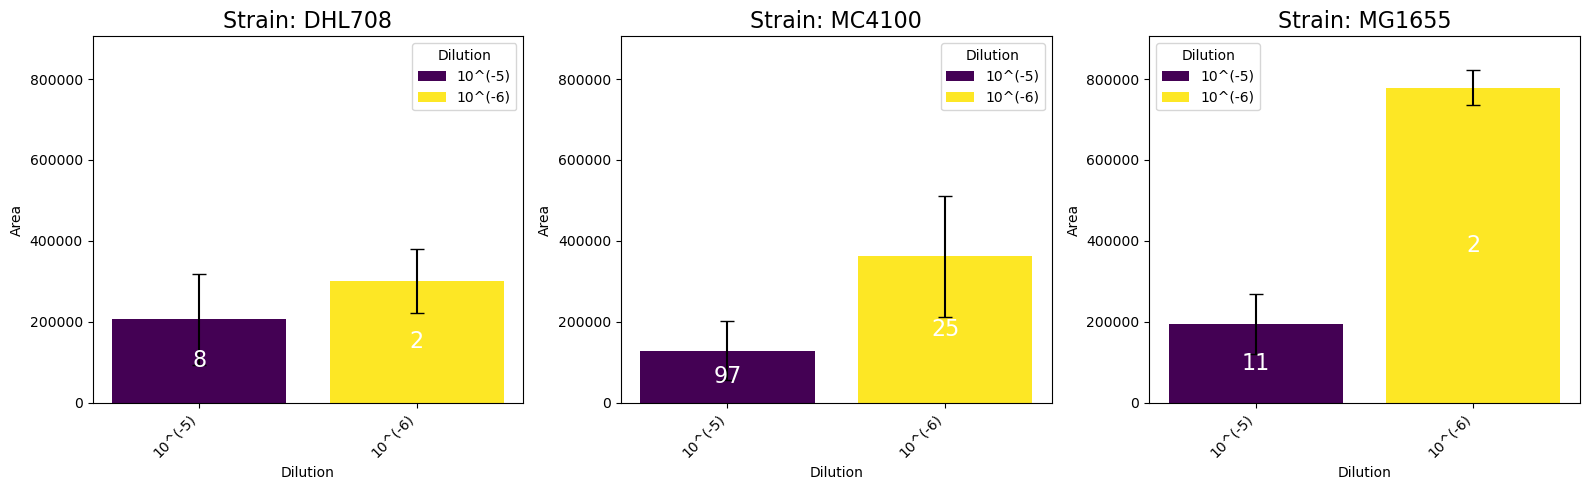

In [199]:
# Group the data by 'Strain', 'Dilution', and calculate mean, standard deviation for 'area' and count colonies
plot_data = df.groupby(['Strain', 'Dilution']).agg({
    'area': ['mean', 'std'],
    'Colonies': 'size'  # This will count the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Strain', 'Dilution', 'Area Mean', 'Area Std', 'Colonies Count']

# Find the global maximum for the y-axis
max_area = plot_data['Area Mean'] + plot_data['Area Std']
global_max = max_area.max()

# Determine the number of subplots needed
unique_strains = plot_data['Strain'].unique()
subplot_count = len(unique_strains)
fig, axes = plt.subplots(nrows=1, ncols=subplot_count, figsize=(16, 5), squeeze=False)
axes = axes.flatten()  # Flatten the axes array for easier access

# Plot each strain's dilution data side by side
for ax, strain in zip(axes, unique_strains):
    sub_data = plot_data[plot_data['Strain'] == strain]
    dilutions = sub_data['Dilution'].unique()
    area_colors = plt.cm.viridis(np.linspace(0, 1, len(dilutions)))
    
    # Plot each dilution for the current strain
    for idx, dilution in enumerate(dilutions):
        dilution_data = sub_data[sub_data['Dilution'] == dilution]
        for i, row in dilution_data.iterrows():
            ax.bar(idx, row['Area Mean'], yerr=row['Area Std'], capsize=5, color=area_colors[idx], label=dilution)
            # Annotate the number of colonies inside the bar
            ax.text(idx, row['Area Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=16)

    ax.set_title(f'Strain: {strain}', fontsize=16)
    ax.set_xlabel('Dilution')
    ax.set_ylabel('Area')
    ax.set_xticks(np.arange(len(dilutions)))
    ax.set_xticklabels(dilutions, rotation=45, ha="right")
    ax.legend(title="Dilution")
    ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits

# Hide any unused axes
for i in range(len(unique_strains), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [237]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

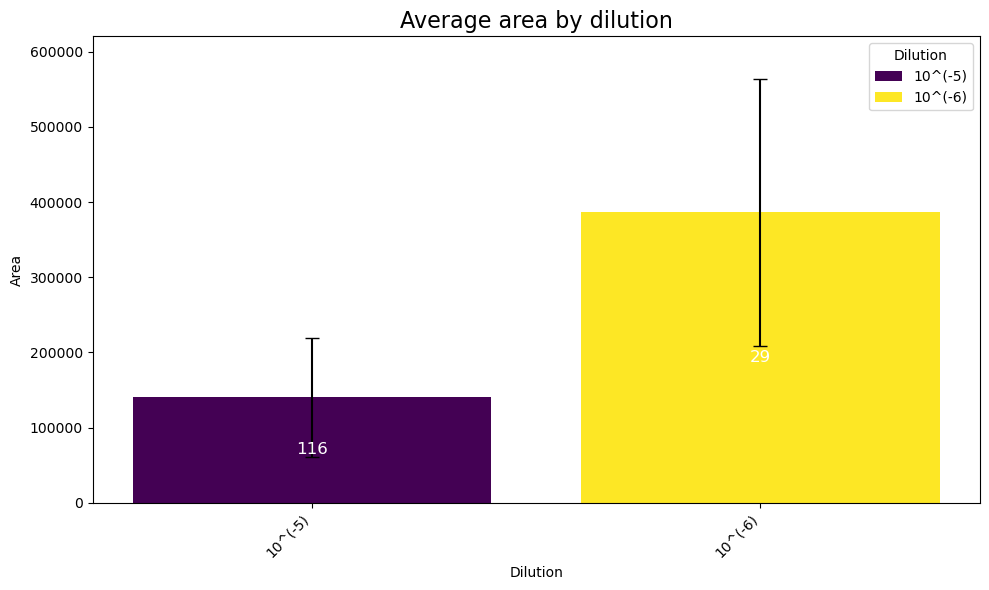

In [238]:
# Group the data by 'Dilution' only, and calculate mean, standard deviation for 'area' and count colonies
plot_data = df.groupby(['Dilution']).agg({
    'area': ['mean', 'std'],
    'Colonies': 'size'  # This counts the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Dilution', 'Area Mean', 'Area Std', 'Colonies Count']

# Find the global maximum for the y-axis to ensure proper scale
max_area = plot_data['Area Mean'] + plot_data['Area Std']
global_max = max_area.max()

# Create a single plot for all dilutions
fig, ax = plt.subplots(figsize=(10, 6))

# Generate a color range
area_colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))

# Plot each dilution
for idx, row in plot_data.iterrows():
    ax.bar(idx, row['Area Mean'], yerr=row['Area Std'], capsize=5, color=area_colors[idx], label=row['Dilution'])
    # Annotate the number of colonies inside the bar
    ax.text(idx, row['Area Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=12)

ax.set_title('Average area by dilution', fontsize=16)
ax.set_xlabel('Dilution')
ax.set_ylabel('Area')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(plot_data['Dilution'], rotation=45, ha="right")
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.legend(title="Dilution")

plt.tight_layout()
plt.show()

fig.savefig('Av_area_dil_bar.png', dpi=300)

In [239]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

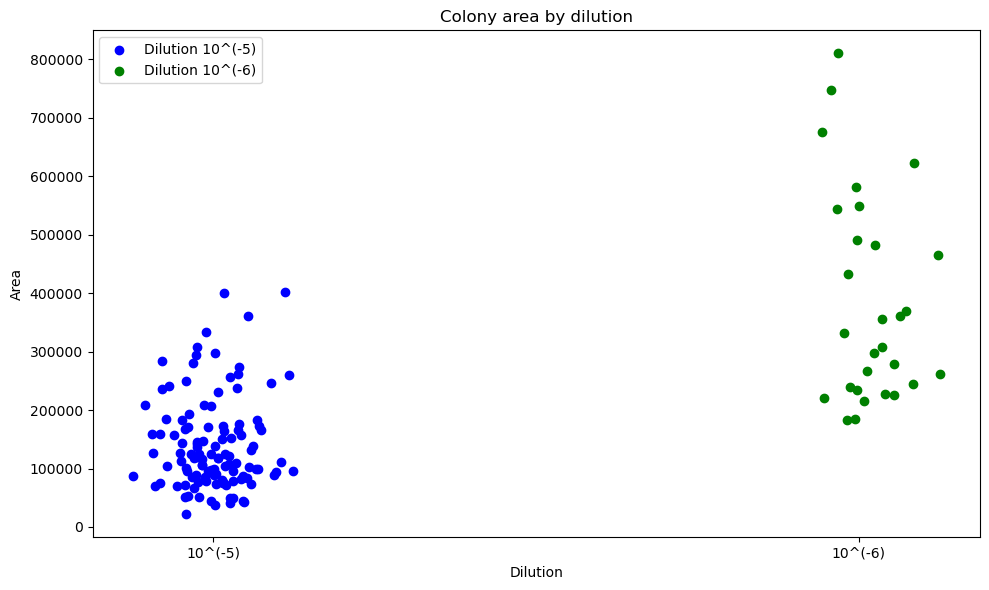

In [240]:
# Colors for each dilution
colors = ['blue', 'green']
dilutions = df['Dilution'].unique()

# Plot with distinct areas for each dilution
fig, ax = plt.subplots(figsize=(10, 6))

for i, dilution in enumerate(dilutions):
    # Create an offset for x positions to visually separate data
    x_positions = np.random.normal(i, 0.05, size=len(df[df['Dilution'] == dilution]))
    sub_data = df[df['Dilution'] == dilution]
    ax.scatter(x_positions, sub_data['area'], color=colors[i], label=f'Dilution {dilution}')

ax.set_title('Colony area by dilution')
ax.set_xlabel('Dilution')
ax.set_ylabel('Area')
ax.set_xticks(np.arange(len(dilutions)))
ax.set_xticklabels(dilutions)
ax.legend()

plt.tight_layout()
plt.show()

fig.savefig('Area_dil_scatter.png', dpi=300)


Make histograms of the above

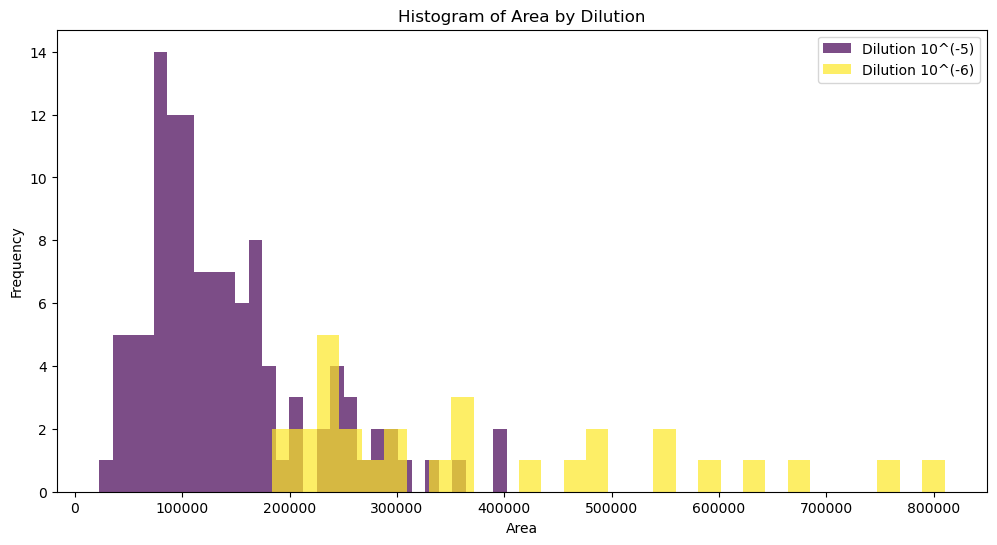

In [128]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

# Assuming there are exactly two dilution groups
dilutions = df['Dilution'].unique()
data1 = df[df['Dilution'] == dilutions[0]]['area'].dropna()
data2 = df[df['Dilution'] == dilutions[1]]['area'].dropna()

colors = plt.cm.viridis(np.linspace(0, 1, len(dilutions)))

# Plotting histograms
plt.figure(figsize=(12, 6))

# Histogram for the first dilution
plt.hist(data1, bins=30, alpha=0.7, label=f'Dilution {dilutions[0]}', color=colors[0])

# Histogram for the second dilution
plt.hist(data2, bins=30, alpha=0.7, label=f'Dilution {dilutions[1]}', color=colors[1])

plt.title('Histogram of Area by Dilution')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('His_Area_dil.png', dpi=300)
plt.show()



In [219]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

# ANOVA test for more than two dilutions
if df['Dilution'].nunique() > 2:
    # Create groups for each dilution
    groups = [group['area'].dropna() for name, group in df.groupby('Dilution')]
    # Perform ANOVA
    f_val, p_val = stats.f_oneway(*groups)
    print("ANOVA test results: F =", f_val, ", P =", p_val)

# Two dilution groups
elif df['Dilution'].nunique() == 2:
    dilutions = df['Dilution'].unique()
    data1 = df[df['Dilution'] == dilutions[0]]['area'].dropna()
    data2 = df[df['Dilution'] == dilutions[1]]['area'].dropna()
    
    # Perform t-test
    t_stat, p_val = stats.ttest_ind(data1, data2)
    print("T-test results: t =", t_stat, ", P =", p_val)

# Additional checks for assumptions (normality check for t-test)
if df['Dilution'].nunique() == 2:
    print("Normality Test for group 1:", stats.shapiro(data1))
    print("Normality Test for group 2:", stats.shapiro(data2))


T-test results: t = -11.1916567831005 , P = 2.8255489504278984e-21
Normality Test for group 1: ShapiroResult(statistic=0.8948546800667634, pvalue=1.597732944686496e-07)
Normality Test for group 2: ShapiroResult(statistic=0.8956199441658065, pvalue=0.007707217791473738)


2

In [ ]:
T-test Results
t-statistic = -11.1916567831005: This value is quite far from zero, indicating a significant difference between the means of the two groups.
The negative sign indicates that the mean of the first group is less than the mean of the second group.
P-value = 2.8255489504278984e-21: This extremely small p-value (far less than 0.05) strongly suggests that the differences in means 
between the two groups are statistically significant. In simpler terms, you can reject the null hypothesis that there is no difference 
between the means of the two groups, and conclude that the dilution levels do have a significant effect on the area.

Normality Test Results
Group 1:
Shapiro-Wilk Statistic = 0.8948546800667634
P-value = 1.597732944686496e-07: This p-value is less than 0.05, indicating that the data for this group does not follow a normal 
distribution.
Group 2:
Shapiro-Wilk Statistic = 0.8956199441658065
P-value = 0.007707217791473738: Similarly, this p-value is also less than 0.05, suggesting that the data for this group are not 
normally distributed either.


In [220]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

# Assuming there are exactly two dilution groups
dilutions = df['Dilution'].unique()
data1 = df[df['Dilution'] == dilutions[0]]['area'].dropna()
data2 = df[df['Dilution'] == dilutions[1]]['area'].dropna()

# Perform Mann-Whitney U test
u_stat, p_val = stats.mannwhitneyu(data1, data2, alternative='two-sided')

print("Mann-Whitney U test results: U =", u_stat, ", P =", p_val)


Mann-Whitney U test results: U = 225.0 , P = 6.047524766825691e-13


In [ ]:
Interpretation:
Statistically Significant Difference: The very low p-value indicates strong evidence against the null hypothesis of the Mann-Whitney U test,
which states that there is a 50% chance that an observation from one group will be larger than an observation from the other group. 
Since the p-value is much smaller than 0.05, you can reject the null hypothesis.

Effect of Dilutions on Area: The results suggest that the dilution levels have a statistically significant effect on the area measurements. 
This means that the differences in area are not likely due to random chance, and there is a systematic difference in area between the two 
dilution groups being tested.
Practical Implications:
Decision Making: Based on this test, if you are in a situation where you are choosing between two dilution treatments (assuming these are the ones tested), there is statistically significant evidence to suggest that one of them leads to a different outcome in terms of area than the other.
Further Research: While the test indicates differences, it doesn't specify which group has the higher area. Further detailed analysis or additional data visualization could help in understanding the direction of this difference (e.g., examining the mean ranks or plotting the distributions). Moreover, examining why these differences occur could be beneficial in a practical setting.
Next Steps:
Examine the Data Further: You might want to look more closely at how the area values are distributed within each group to understand the nature of the differences — are they skewed, do they have outliers, etc.?
Consider Additional Factors: If there are more variables in your dataset, consider whether other factors might influence the relationship between dilution and area. Multivariable statistical methods or regression analysis could provide deeper insights.
This test provides a robust method for determining whether the differences observed in your study are statistically significant, helping guide further research and decision-making processes.

In [223]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

# Assuming there are exactly two dilution groups
dilutions = df['Dilution'].unique()
data1 = df[df['Dilution'] == dilutions[0]]['area'].dropna()
data2 = df[df['Dilution'] == dilutions[1]]['area'].dropna()

# Shapiro-Wilk Test for normality
shapiro_test1 = stats.shapiro(data1)
shapiro_test2 = stats.shapiro(data2)

print(f'Shapiro-Wilk Test for group 1: {shapiro_test1}')
print(f'Shapiro-Wilk Test for group 2: {shapiro_test2}')

# Kolmogorov-Smirnov Test assuming normal distribution
# First, get the normal distribution parameters (mean and std) from the data
ks_test1 = stats.kstest(data1, 'norm', args=(data1.mean(), data1.std()))
ks_test2 = stats.kstest(data2, 'norm', args=(data2.mean(), data2.std()))

print(f'Kolmogorov-Smirnov Test for group 1: {ks_test1}')
print(f'Kolmogorov-Smirnov Test for group 2: {ks_test2}')

# Anderson-Darling Test for normality
anderson_test1 = stats.anderson(data1, dist='norm')
anderson_test2 = stats.anderson(data2, dist='norm')

print(f'Anderson-Darling Test for group 1: {anderson_test1}')
print(f'Anderson-Darling Test for group 2: {anderson_test2}')


Shapiro-Wilk Test for group 1: ShapiroResult(statistic=0.8948546800667634, pvalue=1.597732944686496e-07)
Shapiro-Wilk Test for group 2: ShapiroResult(statistic=0.8956199441658065, pvalue=0.007707217791473738)
Kolmogorov-Smirnov Test for group 1: KstestResult(statistic=0.14390272693078227, pvalue=0.014689568872366082, statistic_location=127239, statistic_sign=1)
Kolmogorov-Smirnov Test for group 2: KstestResult(statistic=0.15757983015701593, pvalue=0.4238651314229607, statistic_location=370160, statistic_sign=1)
Anderson-Darling Test for group 1: AndersonResult(statistic=3.8128734039981538, critical_values=array([0.558, 0.635, 0.762, 0.889, 1.057]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=140464.3448275862, scale=79191.8199571366)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Anderson-Darling Test for group 2: AndersonResult(statistic=1.0579504101067485, critical_values=array([0.52 , 0.592, 0.71

In [ ]:
1. Shapiro-Wilk Test:
Group 1:
Statistic: 0.8948546800667634
P-value: 1.597732944686496e-07
Group 2:
Statistic: 0.8956199441658065
P-value: 0.007707217791473738
Both groups have a p-value less than 0.05, indicating strong evidence against the null hypothesis that the data is normally distributed. 
Thus, the data in both groups are not normally distributed.

2. Kolmogorov-Smirnov Test:
Group 1:
Statistic: 0.14390272693078227
P-value: 0.014689568872366082
Group 2:
Statistic: 0.15757983015701593
P-value: 0.4238651314229607
For Group 1, the p-value is below 0.05, suggesting that the data does not fit the normal distribution used as the model (with the same 
mean and standard deviation as the sample). For Group 2, the p-value is above 0.05, indicating insufficient evidence to reject the 
hypothesis that the data follows the modeled normal distribution; however, this does not confirm normality, especially considering the 
results from other tests.

3. Anderson-Darling Test:
Group 1:
Statistic: 3.8128734039981538
Critical Values: [0.558, 0.635, 0.762, 0.889, 1.057] for significance levels [15%, 10%, 5%, 2.5%, 1%]
Group 2:
Statistic: 1.0579504101067485
Critical Values: [0.52, 0.592, 0.71, 0.828, 0.985] for significance levels [15%, 10%, 5%, 2.5%, 1%]
For both groups, the test statistic exceeds the critical values at a 5% significance level, suggesting the data do not follow a 
normal distribution. This aligns with the Shapiro-Wilk test results and supports the non-normality of the data.

Conclusion:
All tests converge to the same conclusion that the data in both groups do not follow a normal distribution. This influences which 
types of statistical tests should be applied for further analysis, guiding you toward non-parametric methods for any comparative or 
correlative analysis involving these data sets.

- Make plots of 1/A dA/dt (peak average growth rate), compare bar graphs of that as well
- When the colony is smaller the peak growth rate goes up, when the colony is smaller it growths much more quicker.
- High dilutions low growth rates and low dilutions high growth
- Calculate 1/A dA/dt, smooth it out, fin the peak and use it as the value in the bar graph

Overall:
- They grow to bigger colonies in lower dilutions
- They grow faster in slower dilutions (high density)

In [135]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

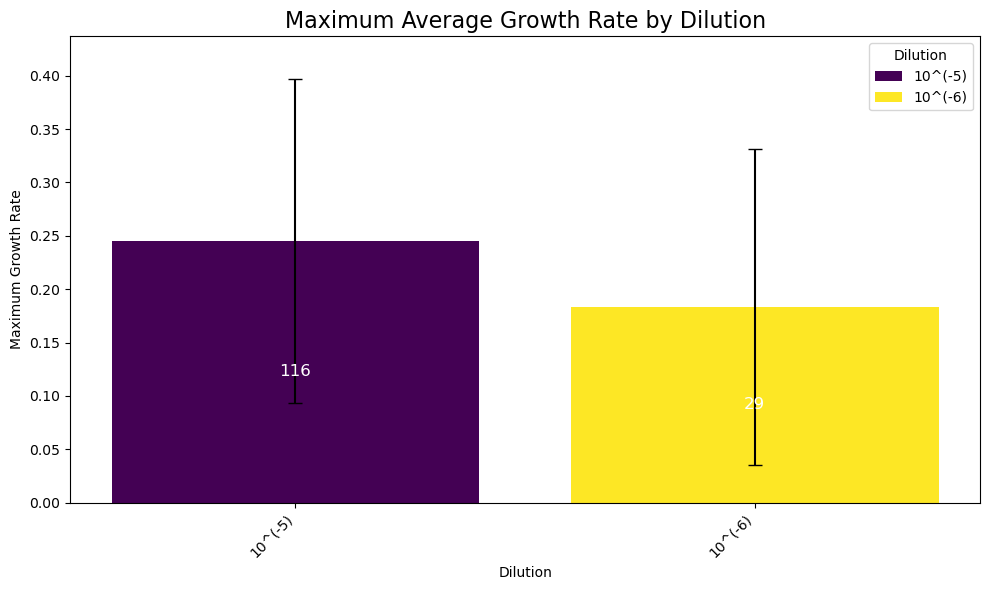

In [136]:
# Group the data by 'Dilution' only, and calculate mean, standard deviation for 'max_av_gr' and count colonies
plot_data = df.groupby(['Dilution']).agg({
    'max_av_gr': ['mean', 'std'],
    'Colonies': 'size'  # This counts the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Dilution', 'Max Av GR Mean', 'Max Av GR Std', 'Colonies Count']

# Find the global maximum for the y-axis to ensure proper scale
max_growth = plot_data['Max Av GR Mean'] + plot_data['Max Av GR Std']
global_max = max_growth.max()

# Create a single plot for all dilutions
fig, ax = plt.subplots(figsize=(10, 6))

# Generate a color range
growth_colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))

# Plot each dilution
for idx, row in plot_data.iterrows():
    ax.bar(idx, row['Max Av GR Mean'], yerr=row['Max Av GR Std'], capsize=5, color=growth_colors[idx], label=row['Dilution'])
    # Annotate the number of colonies inside the bar
    ax.text(idx, row['Max Av GR Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=12)

ax.set_title('Maximum Average Growth Rate by Dilution', fontsize=16)
ax.set_xlabel('Dilution')
ax.set_ylabel('Maximum Growth Rate')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(plot_data['Dilution'], rotation=45, ha="right")
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.legend(title="Dilution")

plt.tight_layout()
plt.show()

fig.savefig('Max_Av_GR_Dil_Bar.png', dpi=300)


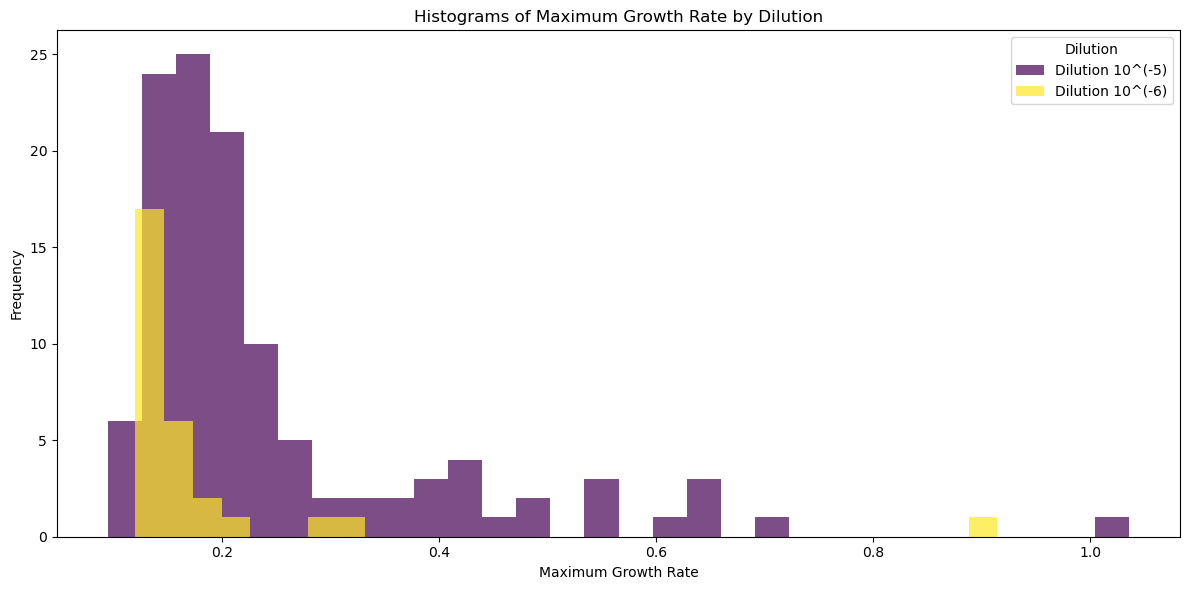

In [134]:
# Ensure that 'max_av_gr' contains only finite values
df = df[np.isfinite(df['max_av_gr'])]  # Filter to keep only rows where 'max_av_gr' is finite

# Retrieve unique dilutions to create histograms for each
unique_dilutions = df['Dilution'].unique()

# Set up the plot
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_dilutions)))

# Plot histograms for each dilution
for i, dilution in enumerate(unique_dilutions):
    data = df[df['Dilution'] == dilution]['max_av_gr']
    plt.hist(data, bins=30, alpha=0.7, label=f'Dilution {dilution}', color=colors[i])

plt.title('Histograms of Maximum Growth Rate by Dilution')
plt.xlabel('Maximum Growth Rate')
plt.ylabel('Frequency')
plt.legend(title="Dilution")
plt.savefig('His_Max_Av_GR_dil.png', dpi=300)
plt.tight_layout()
plt.show()
